Accuracy: 1.00
Confusion Matrix:
[[113   0]
 [  0  12]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       113
           1       1.00      1.00      1.00        12

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125


Top Colleges and Branches:
     NIRF                                       COLLEGE  \
5      48                   SSN College of Engineering    
365    85            Thiagarajar College of Engineering   
121    86               Rajalakshmi Engineering College   
333   108              Kumaraguru College Of Technology   
89    151      Sri Venkateshwara College Of Engineering   
177   151               Chennai Institute Of Technology   
669   157        Sri Sairam Engineering College,Chennai   
397   160  Government College of Engineering,Coimbatore   
705   174             Sona College 

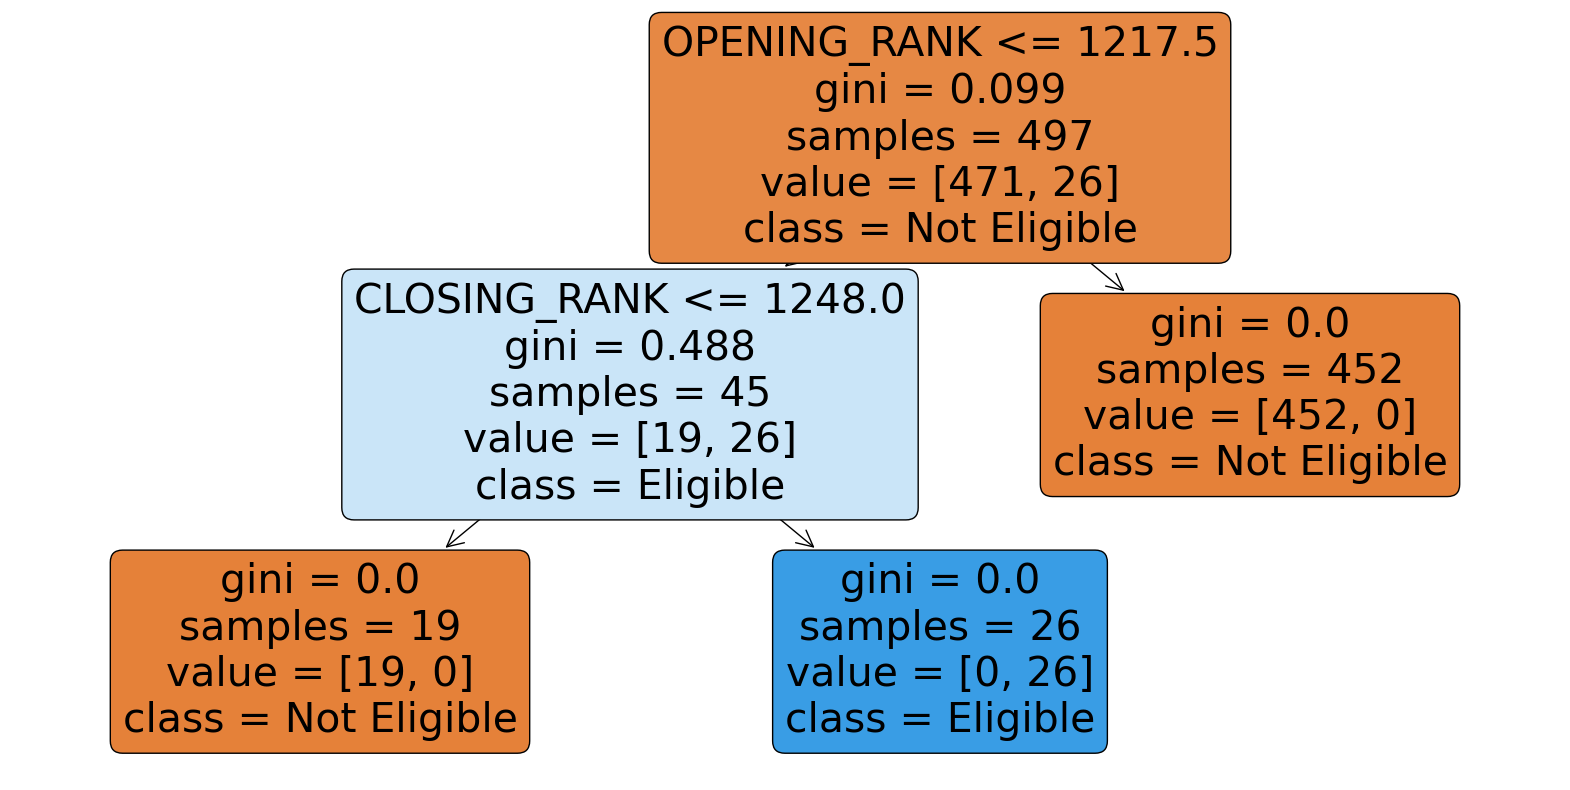

In [12]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Load the dataset
dataset_path = r'C:\Users\matha\OneDrive\Desktop\movie\project_data1.csv'
df = pd.read_csv(dataset_path)

# Drop rows with any null values
df.dropna(inplace=True)

# Encode categorical columns: COLLEGE, BRANCH, CATEGORY
label_encoders = {}
for column in ['COLLEGE', 'BRANCH', 'CATEGORY']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Define a target variable 'eligible' based on rank criteria
def create_eligibility_column(df, student_rank):
    df['eligible'] = ((df['OPENING_RANK'] <= student_rank) & (student_rank <= df['CLOSING_RANK'])).astype(int)
    return df

# Generate eligibility column with a sample rank threshold
student_rank = int(input("Enter your rank: "))
df = create_eligibility_column(df, student_rank)

# Split the data
X = df[['NIRF', 'COLLEGE', 'YEAR', 'BRANCH', 'CATEGORY', 'OPENING_RANK', 'CLOSING_RANK']]
y = df['eligible']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Decision Tree classifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(report)

# Function to get eligible colleges based on rank, community, and branch
def get_top_colleges_with_opening_rank(student_rank, community, branch=None):
    # Encode the community (CATEGORY) input
    community_encoded = label_encoders['CATEGORY'].transform([community])[0]
    
    # Encode the branch input if provided
    if branch:
        branch_encoded = label_encoders['BRANCH'].transform([branch])[0]
    
    # Filter dataset for eligibility
    eligible_df = df[
        (df['CATEGORY'] == community_encoded) &
        (
            ((df['OPENING_RANK'] <= student_rank) & (student_rank <= df['CLOSING_RANK'])) |
            (df['OPENING_RANK'] > student_rank)  # Include colleges with opening rank greater than student's rank
        )
    ]
    
    # If branch is provided, filter by branch
    if branch:
        eligible_df = eligible_df[eligible_df['BRANCH'] == branch_encoded]
    
    # Sort by NIRF rank to get the top-ranked colleges
    eligible_df = eligible_df.sort_values(by='NIRF')

    # Decode COLLEGE and BRANCH names back to original for displaying results
    eligible_df['COLLEGE'] = label_encoders['COLLEGE'].inverse_transform(eligible_df['COLLEGE'])
    eligible_df['BRANCH'] = label_encoders['BRANCH'].inverse_transform(eligible_df['BRANCH'])

    # Return only relevant columns
    return eligible_df[['NIRF', 'COLLEGE', 'BRANCH', 'OPENING_RANK', 'CLOSING_RANK']]

# Example usage of the function
community = input("Enter your community (e.g., GENERAL, SC, ST): ")
branch = input("Enter your branch preference (e.g., CSE, ECE, MECH): ")
top_colleges = get_top_colleges_with_opening_rank(student_rank, community, branch)

print("\nTop Colleges and Branches:")
print(top_colleges)

# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X.columns, class_names=['Not Eligible', 'Eligible'], filled=True, rounded=True)
plt.show()
